## Import necessary libraries

In [2]:

import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.io import imread
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance
from skimage.io import imread
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from skimage.filters import sobel
%pip install imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler





2025-05-31 12:31:01.931842: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 12:31:01.942288: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-31 12:31:02.026428: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-31 12:31:02.101280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748691062.182624    7483 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748691062.20

Note: you may need to restart the kernel to use updated packages.


The original dataset can be found at: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/data

The dataset is a collection of MRI images of patients with Alzheimer's disease and healthy individuals. It's already preprocessed and split into training and testing sets.

In the following code, we split 15% of the training set into a validation set.

In [6]:
source_train_dir = './original_data/train'
source_test_dir = './original_data/test'
target_base = 'data'

split_ratios = [0.85, 0.15]

#Limpeza caso já tenha sido executado este bloco antes
for subset in ['train', 'val', 'test']:
    subset_path = os.path.join(target_base, subset)
    if os.path.exists(subset_path):
        print(f"Removing old {subset} directory...")
        shutil.rmtree(subset_path)

for class_name in os.listdir(source_train_dir):
    class_path = os.path.join(source_train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if not f.startswith('.')] 
    random.shuffle(files)

    total = len(files)
    train_end = int(split_ratios[0] * total)

    train_files = files[:train_end]
    val_files = files[train_end:]

    print(f"{class_name}: Total={total}, Train={len(train_files)}, Val={len(val_files)}")

    for split, split_files in zip(['train', 'val'], [train_files, val_files]):
        split_dir = os.path.join(target_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for file in split_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(split_dir, file)
            shutil.copy2(src, dst)

for class_name in os.listdir(source_test_dir):
    class_path = os.path.join(source_test_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(target_base, 'test', class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    test_files = [f for f in os.listdir(class_path) if not f.startswith('.')]
    print(f"{class_name} Test: {len(test_files)} images")

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(target_class_dir, file)
        shutil.copy2(src, dst)


Removing old train directory...
Removing old val directory...
Removing old test directory...
Moderate Impairment: Total=2560, Train=2176, Val=384
Mild Impairment: Total=2560, Train=2176, Val=384
No Impairment: Total=2560, Train=2176, Val=384
Very Mild Impairment: Total=2560, Train=2176, Val=384
Moderate Impairment Test: 12 images
Mild Impairment Test: 179 images
No Impairment Test: 640 images
Very Mild Impairment Test: 448 images


In the next code block, we print and plot important information about the dataset, including the number of images in each class and subset and also the distribution of images in each class.

Distribution of Images in Each Subset:
Mild Impairment: Train: 2176, Val: 384, Test: 179
Moderate Impairment: Train: 2176, Val: 384, Test: 12
No Impairment: Train: 2176, Val: 384, Test: 640
Very Mild Impairment: Train: 2176, Val: 384, Test: 448


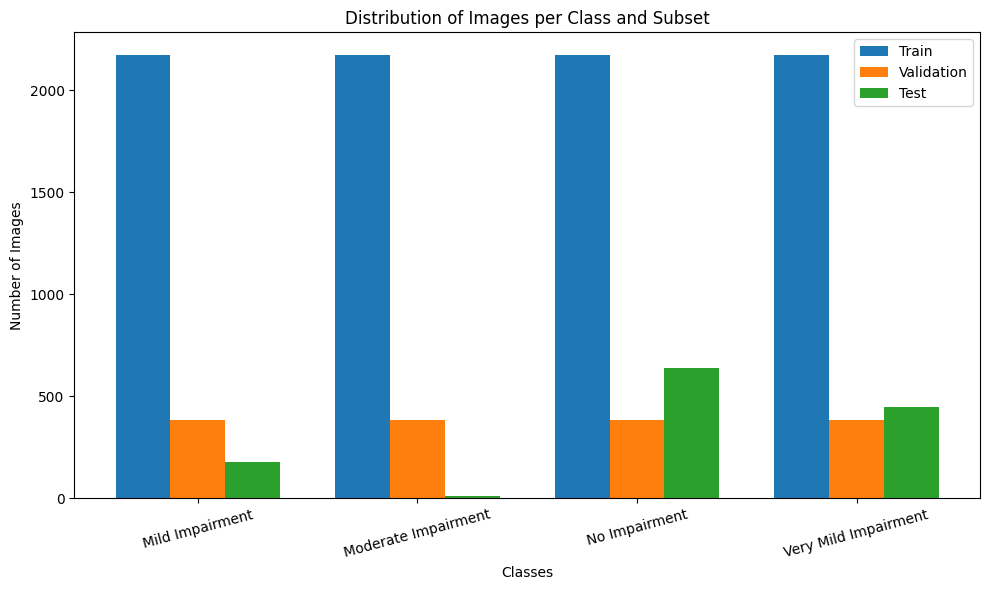

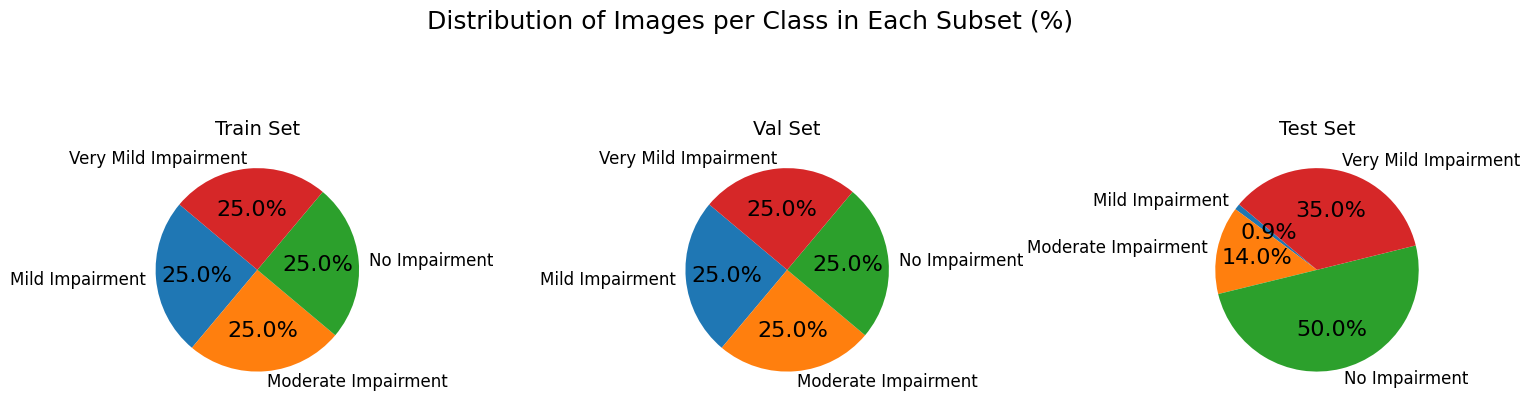

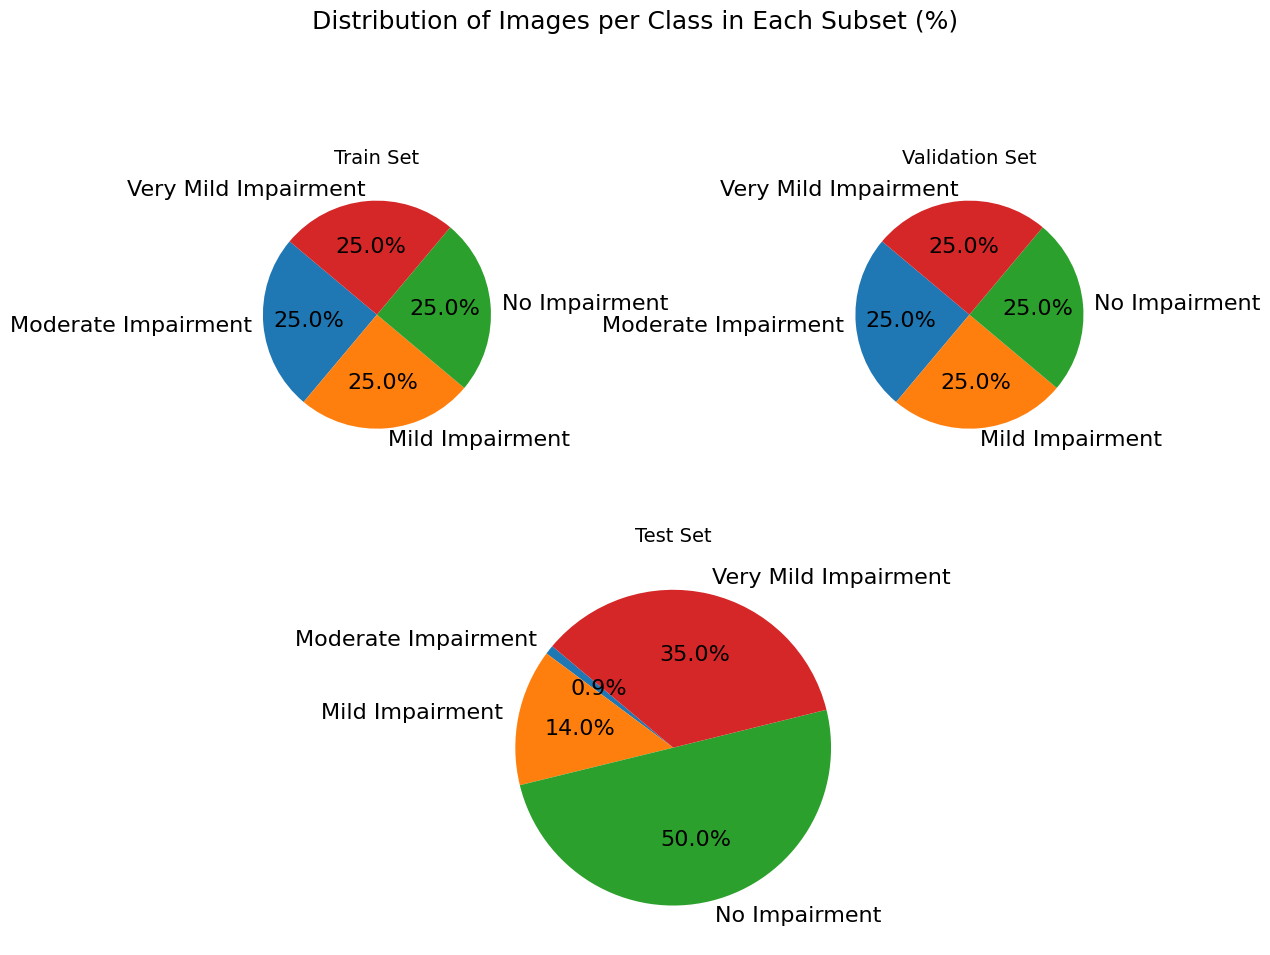

In [ ]:
base_path = "./data" 

data_counts = {
    "train": defaultdict(int),
    "val": defaultdict(int),
    "test": defaultdict(int)
}

for subset in data_counts.keys():
    subset_path = os.path.join(base_path, subset)
    for label in os.listdir(subset_path):
        label_path = os.path.join(subset_path, label)
        count = len(os.listdir(label_path))
        data_counts[subset][label] = count

labels = sorted(list(data_counts["train"].keys()))
x = range(len(labels))
bar_width = 0.25

train_counts = [data_counts["train"][label] for label in labels]
val_counts = [data_counts["val"][label] for label in labels]
test_counts = [data_counts["test"][label] for label in labels]

print("Distribution of Images in Each Subset:")
for label in labels:
    print(f"{label}: Train: {data_counts['train'][label]}, Val: {data_counts['val'][label]}, Test: {data_counts['test'][label]}")

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], train_counts, width=bar_width, label='Train')
plt.bar(x, val_counts, width=bar_width, label='Validation')
plt.bar([i + bar_width for i in x], test_counts, width=bar_width, label='Test')

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class and Subset")
plt.xticks(ticks=x, labels=labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, subset in enumerate(["train", "val", "test"]):
    counts = data_counts[subset]
    values = list(counts.values())

    wedges, texts, autotexts = axes[i].pie(
        values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140
    )

    # Increase font size
    for text in texts:
        text.set_fontsize(12)  # Label font size
    for autotext in autotexts:
        autotext.set_fontsize(16)  # Percentage font size

    axes[i].set_title(f"{subset.capitalize()} Set", fontsize=14)  # Title font size

plt.suptitle("Distribution of Images per Class in Each Subset (%)", fontsize=18)
plt.tight_layout()
plt.savefig("./img/distribution_pie_charts.png", dpi=300)
plt.show()

fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2, figure=fig)

# Axes layout
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Common pie chart style
# Updated common pie chart style
def plot_pie(ax, counts, title):
    wedges, texts, autotexts = ax.pie(
        counts.values(),
        labels=counts.keys(),
        autopct='%1.1f%%',
        startangle=140
    )
    for autotext in autotexts:
        autotext.set_fontsize(16)  # Bigger percentage numbers
    for text in texts:
        text.set_fontsize(16)      # Optional: label font size
    ax.set_title(title, fontsize=14)


# Plot each pie chart
plot_pie(ax1, data_counts["train"], "Train Set")
plot_pie(ax2, data_counts["val"], "Validation Set")
plot_pie(ax3, data_counts["test"], "Test Set")

plt.suptitle("Distribution of Images per Class in Each Subset (%)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./img/distribution_pie_charts_layout.png", dpi=300)
plt.show()



rogosidade, luminosidade, contornos, areas
ferrramentas de processamento de imagem médica ( python, kaggle, ...)
para nos dar as features

CNN ESTUDAR AS CAMADAS E VER OQ ELAS ESTAO A FAZER
neurokit
machine learning com estas features vs deep learning


Here we plot a few sample images from the dataset to visualize the data.

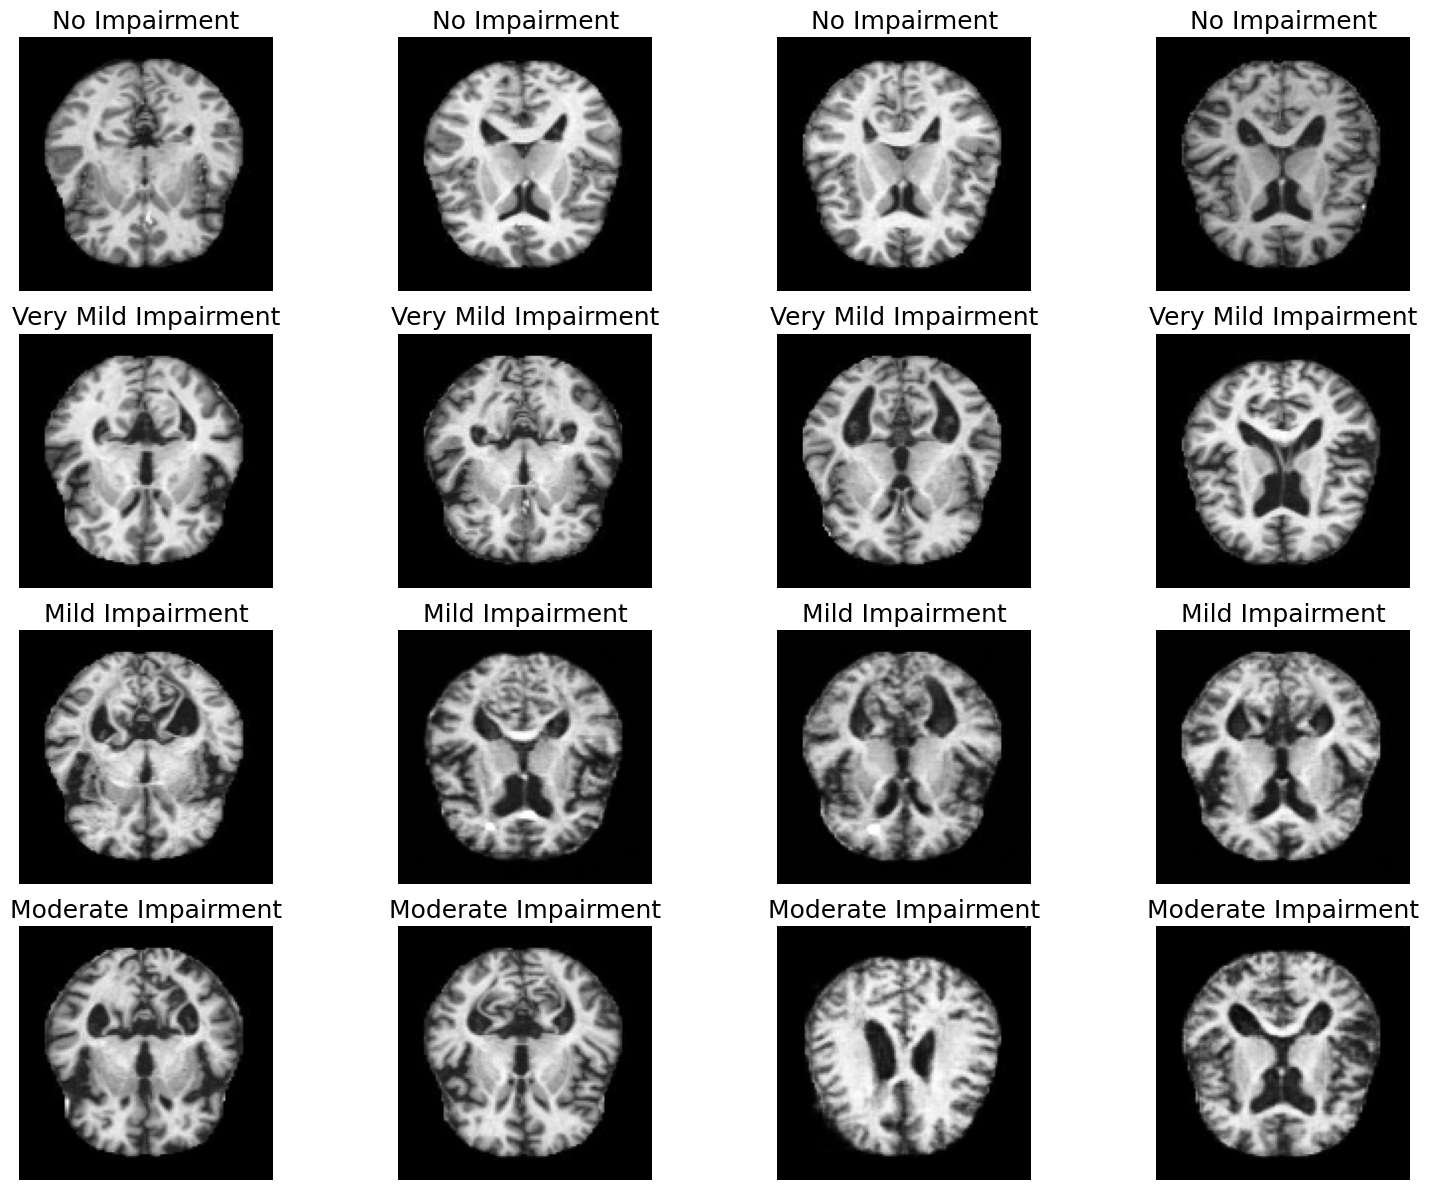

In [4]:
dataset_path = "./data/train"

ordered_classes = [
    "No Impairment",
    "Very Mild Impairment",
    "Mild Impairment",
    "Moderate Impairment"
]

available_classes = os.listdir(dataset_path)
classes = [cls for cls in ordered_classes if cls in available_classes]

n_images = 4  # number of images per class

plt.figure(figsize=(n_images * 4, len(classes) * 3))
img_index = 1

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    for i in range(min(n_images, len(images))):
        img_path = os.path.join(class_path, images[i])
        try:
            img = Image.open(img_path)
            plt.subplot(len(classes), n_images, img_index)
            plt.imshow(img, cmap='gray')
            plt.title(cls, fontsize=18) 
            plt.axis('off')
            img_index += 1
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.savefig("./img/sample_images.png", dpi=300, bbox_inches='tight')
plt.show()


# save the plot as a PNG file



Here we go into more detail about the dataset, including the size of the images, the mode of the images (grayscale or RGB).


Tamanhos de imagem (largura x altura):
(128, 128): 8704 imagens

Modos de cor encontrados:
L: 8704 imagens

Número de imagens por classe:
Mild Impairment: 2176
Moderate Impairment: 2176
No Impairment: 2176
Very Mild Impairment: 2176


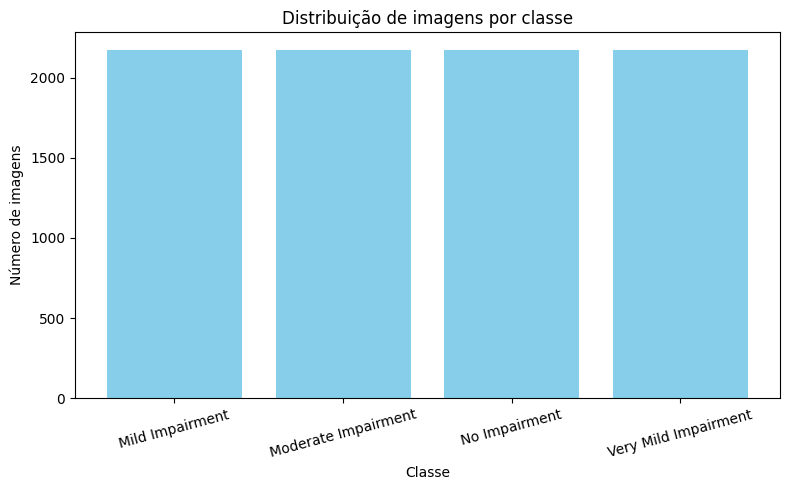

In [5]:
image_shapes = defaultdict(int)
color_modes = defaultdict(int)
class_counts = {}

for cls in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[cls] = len(images)

    for img_file in images:
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                image_shapes[img.size] += 1
                color_modes[img.mode] += 1
        except Exception as e:
            print(f"Erro ao abrir imagem: {img_path}\n{e}")

print("\nTamanhos de imagem (largura x altura):")
for shape, count in image_shapes.items():
    print(f"{shape}: {count} imagens")

print("\nModos de cor encontrados:")
for mode, count in color_modes.items():
    print(f"{mode}: {count} imagens")

print("\nNúmero de imagens por classe:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classe")
plt.ylabel("Número de imagens")
plt.title("Distribuição de imagens por classe")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



## 🧠 Feature Extraction to Create a dataset to be used in a Machine Learning Modal
First we define labels for the classes in the dataset. The labels are as follows:
- No Impairment': 0,
- Very Mild Impairment': 1,
- Mild Impairment': 2,
- Moderate Impairment': 3


### 🔹 `extract_features(image)`

This function takes a single grayscale image as input and extracts a set of quantitative features:

- **Intensity-based features**:
  - `mean_intensity`: Average pixel value
  - `std_intensity`: Standard deviation of pixel values
  - `min_intensity`: Minimum pixel intensity
  - `max_intensity`: Maximum pixel intensity

- **GLCM (Gray-Level Co-occurrence Matrix) texture features**:
  These capture spatial relationships between pixel intensities:
  - `glcm_contrast`
  - `glcm_dissimilarity`
  - `glcm_homogeneity`
  - `glcm_energy`
  - `glcm_correlation`
  - `glcm_ASM`

- **LBP (Local Binary Pattern) histogram features**:
  Describes local texture patterns around each pixel. The result is a normalized histogram:
  - `lbp_bin_0` to `lbp_bin_10`: 11 bins representing frequency of texture patterns.

The function returns a dictionary where keys are feature names and values are the computed measurements.

Then with the function 'build_dataset' we create a dataset with the features extracted from the images.

This function loops through each class folder in the dataset directory and builds a DataFrame of extracted features:

1. Iterates through class-named subdirectories in `image_dir`.
2. Loads each image in grayscale.
3. Applies `extract_features()` to extract feature values.
4. Appends the class label (both string and numeric) to the result.

Returns a `pandas.DataFrame` with:
- One row per image
- Columns for each extracted feature
- `label_name`: The string label (e.g., `'Mild Impairment'`)
- `label`: The corresponding numeric label (e.g., `2`)

This structured dataset is ready for input into classifiers such as Random Forest, SVM, or Logistic Regression.


In [ ]:
from skimage.filters import threshold_otsu, sobel
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.ndimage import laplace


label_encoding = {
    'No Impairment': 0,
    'Very Mild Impairment': 1,
    'Mild Impairment': 2,
    'Moderate Impairment': 3
}

def fractal_dimension(Z):
    def boxcount(Z, k):
        S = Z[:Z.shape[0] - Z.shape[0] % k, :Z.shape[1] - Z.shape[1] % k]
        blocks = S.reshape(S.shape[0] // k, k, S.shape[1] // k, k)
        return np.sum(np.any(np.any(blocks, axis=3), axis=1))
    Z = Z > 0
    sizes = [2, 4, 8, 16]
    counts = [boxcount(Z, size) for size in sizes]
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def extract_features(image):
    features = {}
    image = image.astype(np.uint8)
    h, w = image.shape

    # --- Brain mask (exclude background) ---
    mask = image > 10
    masked_img = image[mask]

    # --- Intensity stats (masked) ---
    features['mean_intensity'] = masked_img.mean()
    features['std_intensity'] = masked_img.std()
    features['max_intensity'] = masked_img.max()
    features['p25_intensity'] = np.percentile(masked_img, 25)
    features['p75_intensity'] = np.percentile(masked_img, 75)
    features['intensity_skew'] = skew(masked_img.ravel())
    features['intensity_kurtosis'] = kurtosis(masked_img.ravel())
    features['median_intensity'] = np.median(masked_img)
    features['intensity_IQR'] = features['p75_intensity'] - features['p25_intensity']

    # --- Entropy & Fractal ---
    features['entropy'] = shannon_entropy(image)
    features['fractal_dim'] = fractal_dimension(image)

    # --- Asymmetry & Central Stats ---
    left, right = image[:, :w//2], image[:, w//2:]
    features['asymmetry_mean'] = abs(np.mean(left) - np.mean(right))
    features['histogram_diff'] = np.sum(np.abs(np.histogram(left, bins=32)[0] - np.histogram(right, bins=32)[0]))

    center_crop = image[h//4:3*h//4, w//4:3*w//4]
    features['center_mean'] = np.mean(center_crop)
    features['center_std'] = np.std(center_crop)
    features['center_dark_ratio'] = np.sum(center_crop < 50) / center_crop.size
    features['center_std_ratio'] = features['center_std'] / (features['std_intensity'] + 1e-6)

    # --- Radial asymmetry (Q1 vs Q3) ---
    q1 = image[:h//2, :w//2]
    q3 = image[h//2:, :w//2]
    features['radial_std_diff'] = np.std(q1) - np.std(q3)

    # --- Sobel edges ---
    edges = sobel(image)
    features['edge_mean'] = np.mean(edges)
    features['edge_std'] = np.std(edges)

    # --- Edge asymmetry ---
    left_edges = sobel(left)
    right_edges = sobel(right)
    features['edge_asymmetry'] = abs(np.mean(left_edges) - np.mean(right_edges))

    # --- Laplacian features ---
    lap = laplace(image)
    features['laplacian_mean'] = lap.mean()
    features['laplacian_std'] = lap.std()

    # --- Compactness & shape ---
    try:
        binary = image > threshold_otsu(image)
        label_img = label(binary)
        regions = regionprops(label_img.astype(int))
        if regions:
            region = max(regions, key=lambda r: r.area)
            area = region.area
            perimeter = region.perimeter
            features['brain_compactness'] = (perimeter**2) / (4 * np.pi * area)
            features['eccentricity'] = region.eccentricity
            features['solidity'] = region.solidity
        else:
            features['brain_compactness'] = 0
            features['eccentricity'] = 0
            features['solidity'] = 0
    except:
        features['brain_compactness'] = 0
        features['eccentricity'] = 0
        features['solidity'] = 0

    # --- GLCM features ---
    glcm = graycomatrix(image, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    glcm_props = {}
    for prop in ['contrast', 'correlation', 'homogeneity', 'ASM']:
        glcm_props[prop] = graycoprops(glcm, prop).mean()
        features[f'glcm_{prop}_mean'] = glcm_props[prop]

    try:
        left_glcm = graycomatrix(left, [1], [0], 256, symmetric=True, normed=True)
        right_glcm = graycomatrix(right, [1], [0], 256, symmetric=True, normed=True)
        features['glcm_contrast_asym'] = abs(graycoprops(left_glcm, 'contrast')[0, 0] -
                                             graycoprops(right_glcm, 'contrast')[0, 0])
    except:
        features['glcm_contrast_asym'] = 0

    features['texture_richness'] = features['entropy'] * glcm_props['contrast']
    features['entropy_std_ratio'] = features['entropy'] / (features['std_intensity'] + 1e-6)
    features['glcm_energy_ratio'] = glcm_props['ASM'] / (glcm_props['contrast'] + 1e-6)

    # --- LBP features ---
    for R in [1, 2, 3]:
        P = 8 * R
        lbp = local_binary_pattern(image, P=P, R=R, method='uniform')
        bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        hist = hist.astype("float") / (hist.sum() + 1e-6)
        for i, val in enumerate(hist):
            features[f'lbp_R{R}_bin_{i}'] = val
        top_bins = np.sort(hist)[-3:]
        features[f'lbp_uniformity_R{R}'] = top_bins.sum()

    # --- FFT features ---
    fft = np.fft.fftshift(np.abs(np.fft.fft2(image)))
    low_band = fft[h//2-8:h//2+8, w//2-8:w//2+8].mean()
    high_band = fft.mean() - low_band
    features['fft_low'] = low_band
    features['fft_high'] = high_band
    features['fft_ratio'] = low_band / (high_band + 1e-6)

    # --- 3x3 regional means & stds ---
    gh, gw = h // 3, w // 3
    for i in range(3):
        for j in range(3):
            patch = image[i*gh:(i+1)*gh, j*gw:(j+1)*gw]
            features[f'region_{i}{j}_mean'] = np.mean(patch)
            features[f'region_{i}{j}_std'] = np.std(patch)

    return features


def build_dataset(image_dir):
    feature_list = []

    for label_name in sorted(os.listdir(image_dir)):
        if label_name not in label_encoding:
            continue
        class_path = os.path.join(image_dir, label_name)
        for img_name in tqdm(os.listdir(class_path), desc=f"Processing '{label_name}'"):
            img_path = os.path.join(class_path, img_name)
            image = imread(img_path, as_gray=True)
            features = extract_features(image)
            features['label_name'] = label_name
            features['label'] = label_encoding[label_name]
            feature_list.append(features)

    df = pd.DataFrame(feature_list)
    return df


Here we use the functions defined above to create a .csv file with the features extracted from the images in the dataset. 

In [7]:
from sklearn.preprocessing import StandardScaler

# --- Build training data ---
dataset_path = 'data/train'
df = build_dataset(dataset_path)

# Save unscaled
df.to_csv('train_features.csv', index=False)

# Scale training features
X_train = df.drop(columns=['label', 'label_name'])
y_train = df[['label', 'label_name']]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
df_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_train_scaled[['label', 'label_name']] = y_train
df_train_scaled.to_csv('train_features_scaled.csv', index=False)

# --- Build validation data ---
dataset_path = 'data/val'
df_val = build_dataset(dataset_path)
df_val.to_csv('val_features.csv', index=False)

X_val = df_val.drop(columns=['label', 'label_name'])
y_val = df_val[['label', 'label_name']]
X_val_scaled = scaler.transform(X_val)
df_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
df_val_scaled[['label', 'label_name']] = y_val
df_val_scaled.to_csv('val_features_scaled.csv', index=False)

# --- Build test data ---
dataset_path = 'data/test'
df_test = build_dataset(dataset_path)
df_test.to_csv('test_features.csv', index=False)

X_test = df_test.drop(columns=['label', 'label_name'])
y_test = df_test[['label', 'label_name']]
X_test_scaled = scaler.transform(X_test)
df_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
df_test_scaled[['label', 'label_name']] = y_test
df_test_scaled.to_csv('test_features_scaled.csv', index=False)

print("Feature extraction complete.")
print("Saved unscaled datasets: train_features.csv, val_features.csv, test_features.csv")
print("Saved scaled datasets: train_features_scaled.csv, val_features_scaled.csv, test_features_scaled.csv")


Processing 'Very Mild Impairment': 100%|██████████| 448/448 [00:21<00:00, 20.51it/s]


Feature extraction complete.
Saved unscaled datasets: train_features.csv, val_features.csv, test_features.csv
Saved scaled datasets: train_features_scaled.csv, val_features_scaled.csv, test_features_scaled.csv


# Visualization of the new dataset generated from the original dataset (images)

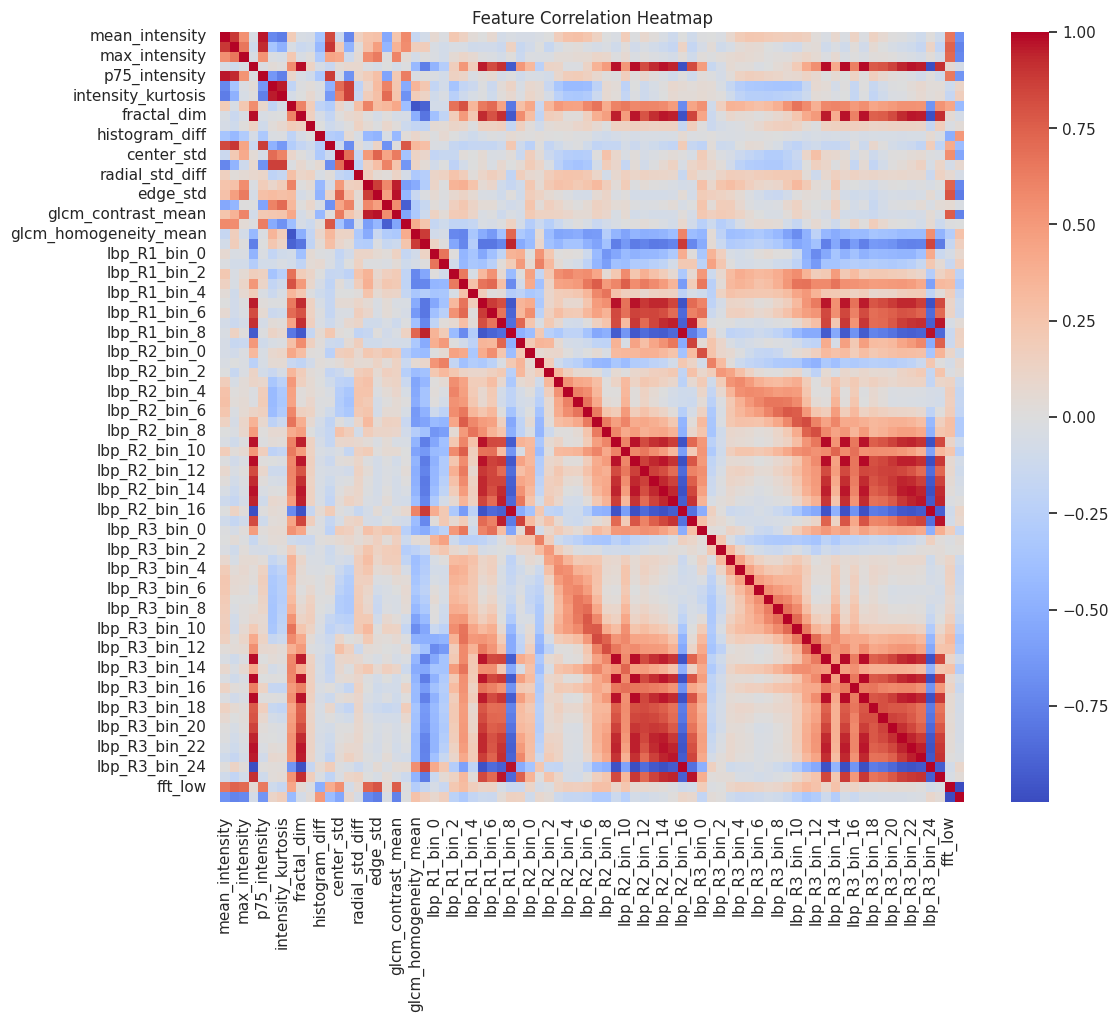

🔍 Dropped 20 highly correlated features.


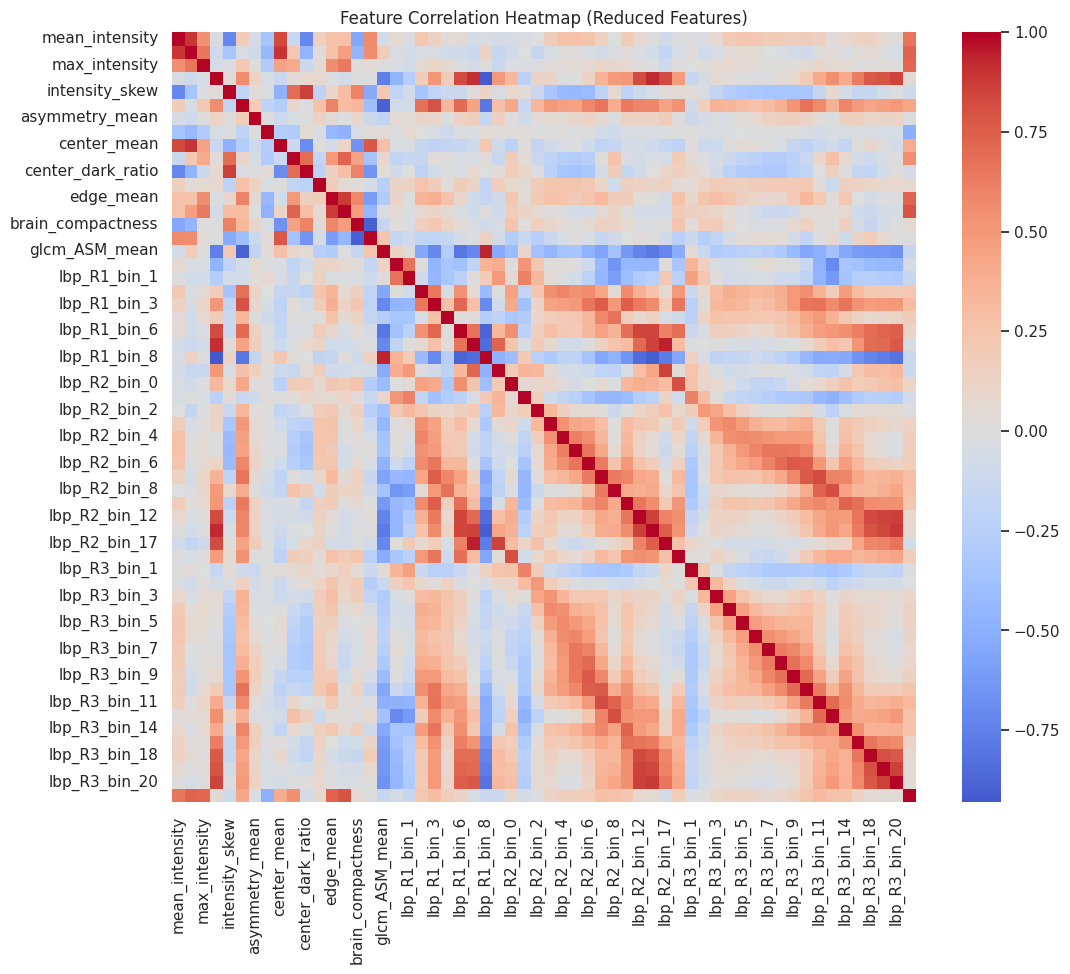

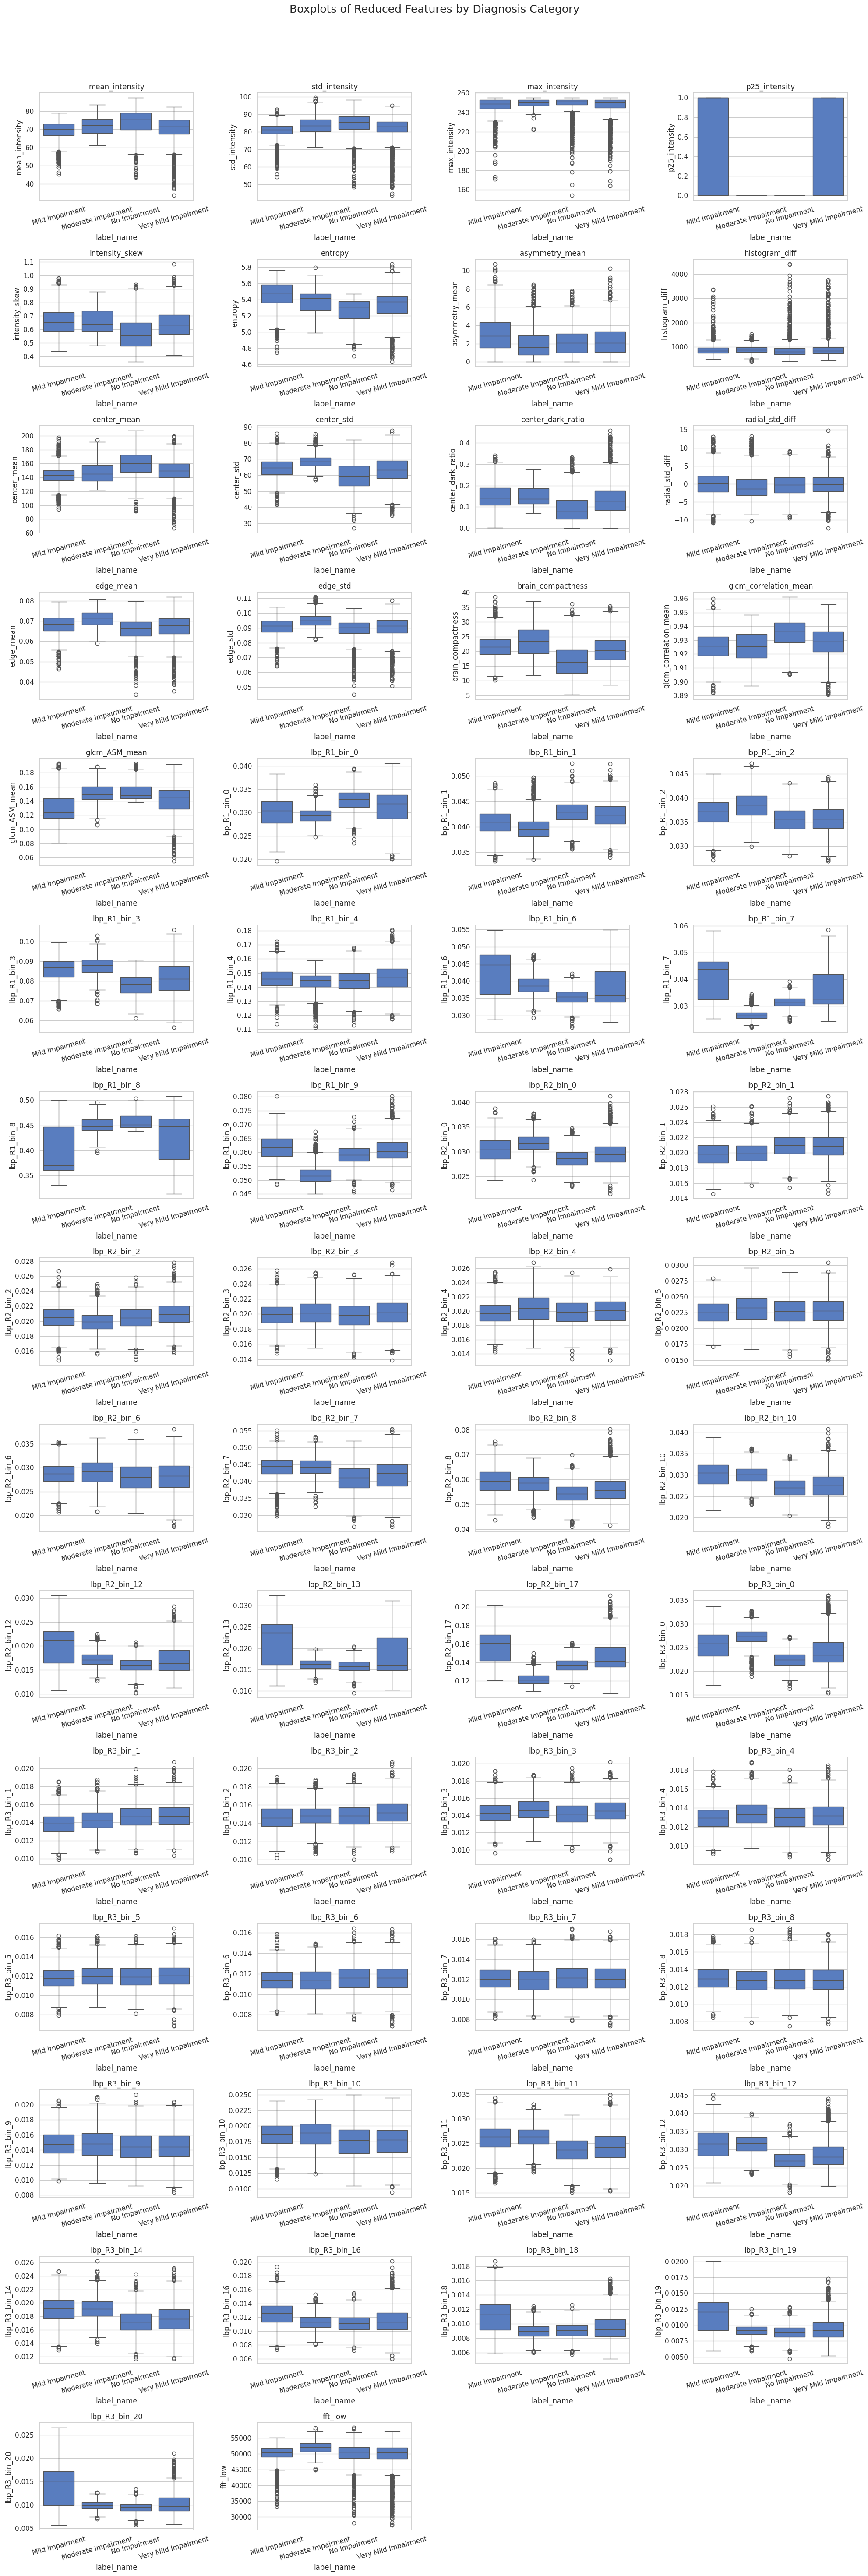

In [ ]:
# --- Load Data ---
df = pd.read_csv("train_features.csv")

# --- Label Mapping ---
label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}
df['label_name'] = df['label'].map(label_map)

# --- Feature Selection (drop labels) ---
numeric_features = df.drop(columns=["label", "label_name"])

# --- Correlation Heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Remove Highly Correlated Features ---
corr_matrix = numeric_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
reduced_features = numeric_features.drop(columns=to_drop)

print(f"🔍 Dropped {len(to_drop)} highly correlated features.")

# --- Correlation Heatmap (Reduced Set) ---
plt.figure(figsize=(12, 10))
sns.heatmap(reduced_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Reduced Features)")
plt.show()

# --- Boxplots for All Reduced Features ---
df_reduced = reduced_features.copy()
df_reduced['label_name'] = df['label_name']

n_features = len(reduced_features.columns)
cols = 4  
rows = (n_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, feature in enumerate(reduced_features.columns):
    sns.boxplot(x='label_name', y=feature, data=df_reduced, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=15)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots of Reduced Features by Diagnosis Category", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


🎯 Final selected features (40):
['lbp_R2_bin_0', 'lbp_R3_bin_12', 'lbp_R2_bin_7', 'lbp_R1_bin_6', 'std_intensity', 'lbp_R3_bin_22', 'center_mean', 'lbp_R3_bin_16', 'center_dark_ratio', 'lbp_R1_bin_0', 'intensity_skew', 'center_std', 'lbp_R3_bin_14', 'lbp_R1_bin_1', 'lbp_R3_bin_0', 'lbp_R3_bin_13', 'fft_low', 'lbp_R2_bin_15', 'lbp_R1_bin_3', 'lbp_R2_bin_10', 'glcm_contrast_mean', 'entropy', 'mean_intensity', 'lbp_R3_bin_18', 'glcm_ASM_mean', 'lbp_R2_bin_13', 'lbp_R2_bin_17', 'lbp_R3_bin_20', 'lbp_R3_bin_11', 'lbp_R1_bin_9', 'brain_compactness', 'lbp_R2_bin_8', 'lbp_R1_bin_2', 'lbp_R2_bin_12', 'lbp_R3_bin_19', 'glcm_correlation_mean', 'lbp_R2_bin_1', 'fractal_dim', 'p25_intensity', 'glcm_homogeneity_mean']

🧪 Validation Performance (Binary)
Balanced Accuracy: 0.8671875
              precision    recall  f1-score   support

Not Impaired       0.61      0.93      0.74       384
    Impaired       0.97      0.80      0.88      1152

    accuracy                           0.84      1536
   m

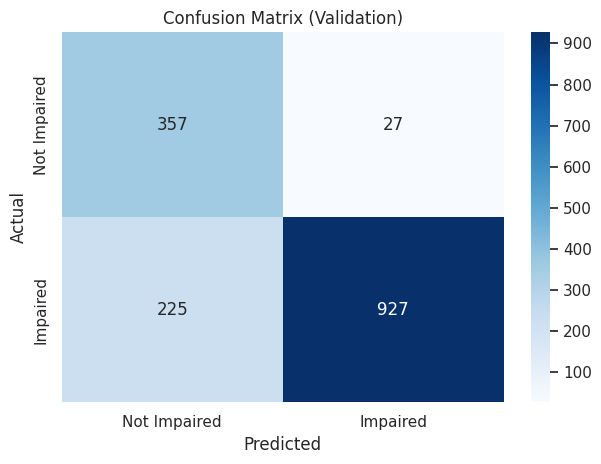


🧪 Test Performance (Binary)
Balanced Accuracy: 0.6831413830203443
              precision    recall  f1-score   support

Not Impaired       0.62      0.95      0.75       640
    Impaired       0.88      0.42      0.57       639

    accuracy                           0.68      1279
   macro avg       0.75      0.68      0.66      1279
weighted avg       0.75      0.68      0.66      1279



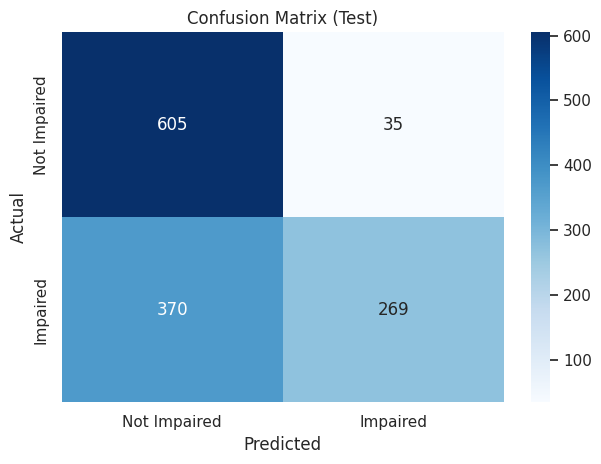

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("train_features.csv")
X_all = df.drop(columns=["label", "label_name"], errors="ignore")
y_all = df["label"]

# --- Step 1: Feature Scores ---
f_scores, pvals = f_classif(X_all, y_all)
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

f_df = pd.DataFrame({"Feature": X_all.columns, "F_score": f_scores, "p_value": pvals})
mi_df = pd.DataFrame({"Feature": X_all.columns, "MI_Score": mi_scores})

top_f = set(f_df.sort_values(by="F_score", ascending=False).head(60)["Feature"])
top_mi = set(mi_df.sort_values(by="MI_Score", ascending=False).head(60)["Feature"])

# --- Step 2: Intersection ---
core_features = list(top_f & top_mi)

# --- Step 3: De-correlation ---
corr_matrix = X_all[core_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
core_decorrelated = [f for f in core_features if f not in to_drop]

# --- Step 4: Add domain-relevant non-redundant features ---
extra_features = ['fractal_dim', 'p25_intensity', 'glcm_ASM_mean', 'glcm_correlation_mean', 'glcm_contrast_mean', 'glcm_homogeneity_mean']
final_features = core_decorrelated + [f for f in extra_features if f not in core_decorrelated]

print(f"🎯 Final selected features ({len(final_features)}):\n{final_features}")

# --- Reload val/test sets ---
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

X_train = X_all[final_features]
X_val = val_df[final_features]
X_test = test_df[final_features]
y_val = val_df['label']
y_test = test_df['label']

X_train_final = X_train           
X_val_final = X_val
X_test_final = X_test

# --- Train BalancedRandomForest ---
clf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=16,  # optionally tuned
    min_samples_leaf=5,
    sampling_strategy='auto',
    replacement=False,
    random_state=42
)
clf.fit(X_train_final, y_all)

# --- Evaluation ---
label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}

def evaluate_set(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map.values(), digits=4))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

evaluate_set(X_val_final, y_val, "Validation Set")
evaluate_set(X_test_final, y_test, "Test Set")


Random Forest Classifier

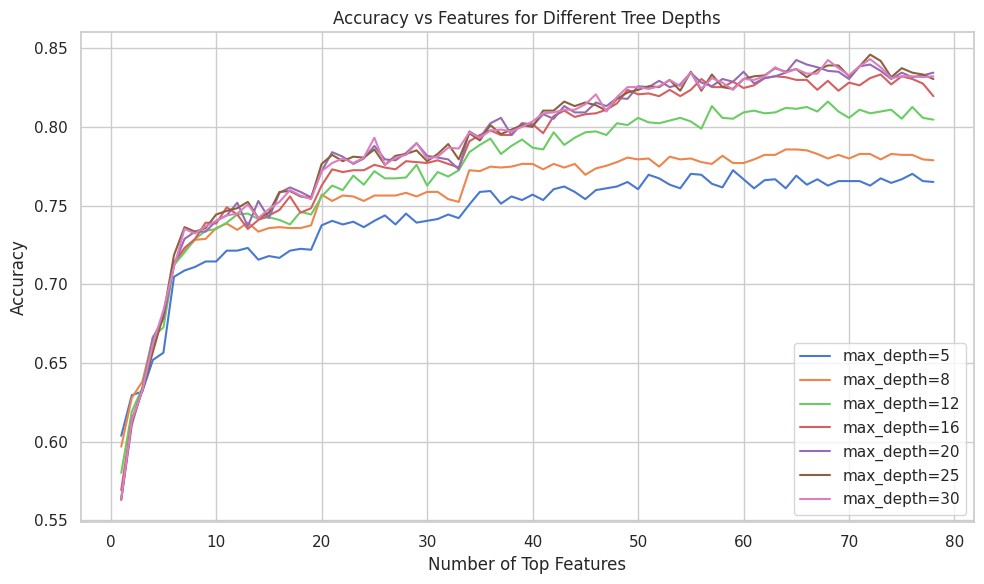


✅ Best accuracy = 0.8432 using top 72 features
Top 72 features:
 ['lbp_R2_bin_17', 'lbp_R1_bin_7', 'lbp_R1_bin_9', 'lbp_R3_bin_25', 'lbp_R2_bin_15', 'fractal_dim', 'lbp_R3_bin_23', 'lbp_R3_bin_17', 'lbp_R2_bin_14', 'lbp_R2_bin_11', 'lbp_R3_bin_24', 'lbp_R3_bin_15', 'p25_intensity', 'lbp_R2_bin_16', 'lbp_R3_bin_13', 'lbp_R3_bin_22', 'lbp_R3_bin_21', 'lbp_R2_bin_9', 'lbp_R3_bin_20', 'lbp_R1_bin_5', 'lbp_R3_bin_0', 'lbp_R1_bin_8', 'lbp_R2_bin_13', 'lbp_R3_bin_19', 'lbp_R1_bin_3', 'lbp_R2_bin_12', 'lbp_R1_bin_6', 'lbp_R3_bin_12', 'glcm_ASM_mean', 'lbp_R2_bin_10', 'lbp_R3_bin_18', 'lbp_R2_bin_0', 'lbp_R1_bin_1', 'brain_compactness', 'lbp_R3_bin_14', 'center_std', 'lbp_R1_bin_0', 'entropy', 'lbp_R1_bin_2', 'lbp_R2_bin_8', 'lbp_R3_bin_11', 'center_mean', 'center_dark_ratio', 'lbp_R2_bin_7', 'edge_mean', 'glcm_correlation_mean', 'glcm_contrast_mean', 'intensity_skew', 'edge_std', 'lbp_R3_bin_16', 'intensity_kurtosis', 'lbp_R2_bin_1', 'glcm_homogeneity_mean', 'mean_intensity', 'fft_low', 'fft_

In [38]:
# --- Load and prepare data ---
df = pd.read_csv("train_features.csv")
X_all = df.drop(columns=['label', 'label_name'], errors='ignore')
y = df['label']

# --- Rank features by ANOVA F-score ---
f_scores, _ = f_classif(X_all, y)
f_df = pd.DataFrame({
    "Feature": X_all.columns,
    "F_score": f_scores
}).sort_values(by="F_score", ascending=False)

# --- Try increasing number of top features ---
max_features = len(f_df)
accuracies = []

depths = [5, 8, 12, 16, 20, 25, 30]
results = []

for d in depths:
    accuracies = []
    for n in range(1, len(f_df) + 1):
        top_n_features = f_df['Feature'].iloc[:n].tolist()
        X_subset = X_all[top_n_features]

        X_train, X_test, y_train, y_test = train_test_split(
            X_subset, y, stratify=y, test_size=0.2, random_state=42
        )

        clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=d,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=42
        )
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        accuracies.append(acc)
    
    results.append((d, accuracies))

plt.figure(figsize=(10, 6))
for d, accs in results:
    plt.plot(range(1, len(accs)+1), accs, label=f"max_depth={d}")
plt.xlabel("Number of Top Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Features for Different Tree Depths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Print best result ---
best_n = max(range(1, max_features + 1), key=lambda i: accuracies[i - 1])
print(f"\n✅ Best accuracy = {accuracies[best_n - 1]:.4f} using top {best_n} features")
print(f"Top {best_n} features:\n", f_df['Feature'].iloc[:best_n].tolist())



✅ Best Accuracy = 0.8478 using top 64 features and depth 20
Top features:
['lbp_R2_bin_17', 'lbp_R1_bin_7', 'lbp_R1_bin_9', 'lbp_R3_bin_25', 'lbp_R2_bin_15', 'fractal_dim', 'lbp_R3_bin_23', 'lbp_R3_bin_17', 'lbp_R2_bin_14', 'lbp_R2_bin_11', 'lbp_R3_bin_24', 'lbp_R3_bin_15', 'p25_intensity', 'lbp_R2_bin_16', 'lbp_R3_bin_13', 'lbp_R3_bin_22', 'lbp_R3_bin_21', 'lbp_R2_bin_9', 'lbp_R3_bin_20', 'lbp_R1_bin_5', 'lbp_R3_bin_0', 'lbp_R1_bin_8', 'lbp_R2_bin_13', 'lbp_R3_bin_19', 'lbp_R1_bin_3', 'lbp_R2_bin_12', 'lbp_R1_bin_6', 'lbp_R3_bin_12', 'glcm_ASM_mean', 'lbp_R2_bin_10', 'lbp_R3_bin_18', 'lbp_R2_bin_0', 'lbp_R1_bin_1', 'brain_compactness', 'lbp_R3_bin_14', 'center_std', 'lbp_R1_bin_0', 'entropy', 'lbp_R1_bin_2', 'lbp_R2_bin_8', 'lbp_R3_bin_11', 'center_mean', 'center_dark_ratio', 'lbp_R2_bin_7', 'edge_mean', 'glcm_correlation_mean', 'glcm_contrast_mean', 'intensity_skew', 'edge_std', 'lbp_R3_bin_16', 'intensity_kurtosis', 'lbp_R2_bin_1', 'glcm_homogeneity_mean', 'mean_intensity', 'fft_lo

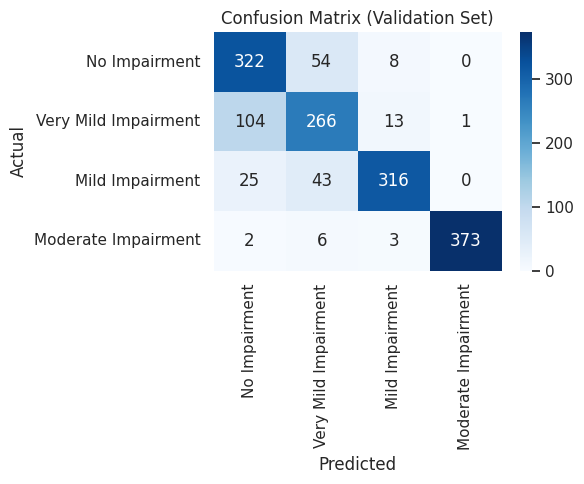


🧪 Test Set Performance
Accuracy: 0.6630179827990618
Balanced Accuracy: 0.438320530726257
                      precision    recall  f1-score   support

       No Impairment     0.7149    0.8031    0.7564       640
Very Mild Impairment     0.5796    0.6094    0.5941       448
     Mild Impairment     0.6932    0.3408    0.4569       179
 Moderate Impairment     0.0000    0.0000    0.0000        12

            accuracy                         0.6630      1279
           macro avg     0.4969    0.4383    0.4519      1279
        weighted avg     0.6578    0.6630    0.6506      1279



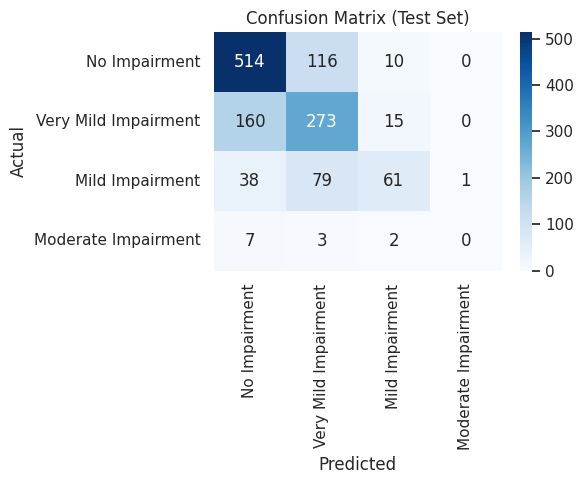

In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and prepare training data for feature ranking ---
train_df = pd.read_csv("train_features.csv")
X_all = train_df.drop(columns=['label', 'label_name'], errors='ignore')
y_all = train_df['label']

# --- Rank features using ANOVA F-score ---
f_scores, _ = f_classif(X_all, y_all)
f_df = pd.DataFrame({
    "Feature": X_all.columns,
    "F_score": f_scores
}).sort_values(by="F_score", ascending=False)

# --- Tune number of features and tree depth ---
max_features = len(f_df)
depths = [5, 8, 12, 16, 20, 25, 30]
best_score = -1
best_config = (None, None)

for d in depths:
    for n in range(1, max_features + 1):
        top_n_features = f_df['Feature'].iloc[:n].tolist()
        X_subset = X_all[top_n_features]
        X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
            X_subset, y_all, stratify=y_all, test_size=0.2, random_state=42
        )
        clf = BalancedRandomForestClassifier(
            n_estimators=100,
            max_depth=d,
            min_samples_leaf=5,
            random_state=42
        )

        clf.fit(X_train_tmp, y_train_tmp)
        acc = accuracy_score(y_test_tmp, clf.predict(X_test_tmp))

        if acc > best_score:
            best_score = acc
            best_config = (n, d)

best_n, best_depth = best_config
top_features = f_df['Feature'].iloc[:best_n].tolist()

print(f"\n✅ Best Accuracy = {best_score:.4f} using top {best_n} features and depth {best_depth}")
print(f"Top features:\n{top_features}")

# Reload real train/val/test sets
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

X_train = X_all[top_features]
y_train = y_all
X_val = val_df[top_features]
y_val = val_df['label']
X_test = test_df[top_features]
y_test = test_df['label']

# --- Standardize and PCA ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

class_weight = {
    0: 1.0,  # No Impairment
    1: 1.0,  # Very Mild
    2: 2.0,  # Mild (more important)
    3: 3.0   # Moderate (most important)
}
# --- Train final model ---
clf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=best_depth,
    min_samples_leaf=5,
    sampling_strategy='auto',
    replacement=False,
    random_state=42
)

clf.fit(X_train_pca, y_train)

# --- Evaluation ---
label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}

def evaluate_set(X, y, dataset_name="Set"):
    y_pred = clf.predict(X)
    print(f"\n🧪 {dataset_name} Performance")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map.values(), digits=4))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Run evaluations
evaluate_set(X_val_pca, y_val, "Validation Set")
evaluate_set(X_test_pca, y_test, "Test Set")




In [40]:
train_df = pd.read_csv("train_features.csv")
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}

# --- Prepare Data ---
X_train_all = train_df.drop(columns=['label', 'label_name'], errors='ignore')
y_train = train_df['label']
X_val_all = val_df.drop(columns=['label', 'label_name'], errors='ignore')
y_val = val_df['label']
X_test_all = test_df.drop(columns=['label', 'label_name'], errors='ignore')
y_test = test_df['label']

# --- Rank Top 18 Features from Training Set ---
f_scores, _ = f_classif(X_train_all, y_train)
f_df = pd.DataFrame({
    "Feature": X_train_all.columns,
    "F_score": f_scores
}).sort_values(by="F_score", ascending=False)

top_features = f_df['Feature'].iloc[:60].tolist()

X_train = X_train_all[top_features]
X_val = X_val_all[top_features]
X_test = X_test_all[top_features]

# --- Train XGBoost Model ---
depths = [3, 5, 7, 10, 12, 15, 20, 23, 25, 28, 30, 35, 40]
best_depth = None
best_accuracy = 0

for depth in depths:
    model = XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=depth,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Depth {depth}: Accuracy = {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_depth = depth

print(f"\n✅ Best depth = {best_depth} with accuracy = {best_accuracy:.4f}")

model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=best_depth,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
y_val_pred = model.predict(X_val)
print("\n🧪 XGBoost Validation Set Performance")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=label_map.values()))

# --- Evaluate on Test Set ---
y_test_pred = xgb_model.predict(X_test)
print("\n🧪 XGBoost Test Set Performance")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=label_map.values()))

# --- Confusion Matrix for Test Set ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Feature Importances ---
plt.figure(figsize=(8, 6))
plot_importance(xgb_model, importance_type='gain', height=0.5, show_values=False)
plt.title("XGBoost Feature Importances (Gain)")
plt.tight_layout()
plt.show()

/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:45:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 3: Accuracy = 0.7969


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:45:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 5: Accuracy = 0.8320


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:45:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 7: Accuracy = 0.8483


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:45:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 10: Accuracy = 0.8613


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:45:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 12: Accuracy = 0.8594


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:45:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 15: Accuracy = 0.8737


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:46:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 20: Accuracy = 0.8633


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:46:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 23: Accuracy = 0.8646


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:46:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 25: Accuracy = 0.8626


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:46:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 28: Accuracy = 0.8711


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 30: Accuracy = 0.8691


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 35: Accuracy = 0.8665


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Depth 40: Accuracy = 0.8665

✅ Best depth = 15 with accuracy = 0.8737


NotFittedError: need to call fit or load_model beforehand

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance

# --- Load Data ---
train_df = pd.read_csv("train_features.csv")
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}

# --- Prepare Data ---
X_train_all = train_df.drop(columns=['label', 'label_name'], errors='ignore')
y_train = train_df['label']
X_val_all = val_df.drop(columns=['label', 'label_name'], errors='ignore')
y_val = val_df['label']
X_test_all = test_df.drop(columns=['label', 'label_name'], errors='ignore')
y_test = test_df['label']

f_scores, _ = f_classif(X_train_all, y_train)
f_df = pd.DataFrame({
    "Feature": X_train_all.columns,
    "F_score": f_scores
}).sort_values(by="F_score", ascending=False)

top_features = f_df['Feature'].iloc[:72].tolist()
X_train = X_train_all[top_features]
X_val = X_val_all[top_features]
X_test = X_test_all[top_features]

class_weights = {
    0: 1.0,
    1: 1.5,
    2: 2.5,
    3: 9
}
sample_weights = y_train.map(class_weights)

model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    use_label_encoder=False,
    eval_metric='mlogloss',
    reg_alpha=1,    # L1 regularization
    reg_lambda=1,   # L2 regularization
    random_state=42
)

model.fit(
    X_train, y_train,
    sample_weight=sample_weights
)

# --- Evaluate on Validation Set ---
y_val_pred = model.predict(X_val)
print("\n🧪 XGBoost Validation Set Performance")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=label_map.values()))

# --- Evaluate on Test Set ---
y_test_pred = model.predict(X_test)
print("\n🧪 XGBoost Test Set Performance")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=label_map.values()))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Feature Importances ---
plt.figure(figsize=(8, 6))
plot_importance(model, importance_type='gain', height=0.5, show_values=False)
plt.title("XGBoost Feature Importances (Gain)")
plt.tight_layout()
plt.show()

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 150],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    use_label_encoder=False,
    eval_metric='mlogloss',
    reg_alpha=1,
    reg_lambda=1,
    random_state=42
)

grid_search = GridSearchCV(
    xgb,
    param_grid,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3),
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train, sample_weight=sample_weights)
best_model = grid_search.best_estimator_



/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:41:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminhos
train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

# Parâmetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

# Apenas normalização (sem augmentation)
datagen = ImageDataGenerator(rescale=1./255)

# Carregar datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Base MobileNetV2 pré-treinada (sem as camadas finais)
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Inicialmente congelar

# Construir modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compilar
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=2, factor=0.5)

# Treinar
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# ➤ FINE-TUNING: Descongela parte da base
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar novamente com fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# Avaliar
loss, acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {acc:.2%}")


Found 8704 images belonging to 4 classes.
Found 1536 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


2025-05-10 23:15:19.513162: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


/home/alof/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


222/272 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.5310 - loss: 1.1839 

KeyboardInterrupt: 